In [1]:
!wget https://github.com/CSP-GD/notes/raw/master/practice/file_format/gltf%E6%A0%BC%E5%BC%8F%E8%A7%A3%E6%9E%90/gltf-tools.ipynb -O gltf-tools.ipynb
%run ./gltf-tools.ipynb

--2020-04-26 10:26:15--  https://github.com/CSP-GD/notes/raw/master/practice/file_format/gltf%E6%A0%BC%E5%BC%8F%E8%A7%A3%E6%9E%90/gltf-tools.ipynb
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/CSP-GD/notes/master/practice/file_format/gltf%E6%A0%BC%E5%BC%8F%E8%A7%A3%E6%9E%90/gltf-tools.ipynb [following]
--2020-04-26 10:26:15--  https://raw.githubusercontent.com/CSP-GD/notes/master/practice/file_format/gltf%E6%A0%BC%E5%BC%8F%E8%A7%A3%E6%9E%90/gltf-tools.ipynb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6637 (6.5K) [text/plain]
Saving to: ‘gltf-tools.ipynb’

gltf-tools.ipynb    100%[==============

In [16]:
!wget https://raw.githubusercontent.com/tensorflow/lucid/master/lucid/misc/gl/glcontext.py -O glcontext.py
%run ./glcontext.py

--2020-04-26 10:49:07--  https://raw.githubusercontent.com/tensorflow/lucid/master/lucid/misc/gl/glcontext.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3866 (3.8K) [text/plain]
Saving to: ‘glcontext.py’

glcontext.py        100%[===================>]   3.78K  --.-KB/s    in 0s      

2020-04-26 10:49:07 (26.1 MB/s) - ‘glcontext.py’ saved [3866/3866]



In [2]:
!wget https://github.com/CSP-GD/notes/raw/master/practice/file_format/gltf%E6%A0%BC%E5%BC%8F%E8%A7%A3%E6%9E%90/mesh/cube.glb -O cube.glb
glb_file = open('./cube.glb', 'rb')
glb_bytes = glb_file.read()
model, buffers = glTF_tools.glb_loader(glb_bytes)

--2020-04-26 10:26:20--  https://github.com/CSP-GD/notes/raw/master/practice/file_format/gltf%E6%A0%BC%E5%BC%8F%E8%A7%A3%E6%9E%90/mesh/cube.glb
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/CSP-GD/notes/master/practice/file_format/gltf%E6%A0%BC%E5%BC%8F%E8%A7%A3%E6%9E%90/mesh/cube.glb [following]
--2020-04-26 10:26:20--  https://raw.githubusercontent.com/CSP-GD/notes/master/practice/file_format/gltf%E6%A0%BC%E5%BC%8F%E8%A7%A3%E6%9E%90/mesh/cube.glb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2280 (2.2K) [application/octet-stream]
Saving to: ‘cube.glb’

cube.glb            100%[=================

In [3]:
glTF_tools.render_JSON(model)

##### Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Using OpenGL with Colab Cloud GPUs

This notebook demonstrates obtaining OpenGL context on GPU Colab kernels.

In [0]:
!pip install -q moviepy

In [0]:
import numpy as np
import json
import moviepy.editor as mvp
from google.colab import files
import PIL


In [7]:
# Now it's safe to import OpenGL and EGL functions
import OpenGL.GL as gl

# create_opengl_context() creates GL context that is attached to an
# offscreen surface of specified size. Note that rendering to buffers
# of different size and format is still possible with OpenGL Framebuffers.
#
# Users are expected to directly use EGL calls in case more advanced
# context management is required.
WIDTH, HEIGHT = 640, 480
create_opengl_context((WIDTH, HEIGHT))
    
# OpenGL context is available here.

print(gl.glGetString(gl.GL_VERSION))
print(gl.glGetString(gl.GL_VENDOR)) 
#print(gl.glGetString(gl.GL_EXTENSIONS))

b'4.6.0 NVIDIA 418.67'
b'NVIDIA Corporation'


In [0]:
vert = """
#version 330

// 物件預設頂點位置
layout (location = 0) in vec3 POSITION;

// 物件姿態矩陣
uniform mat4 u_Posture;
// 鏡頭焦距
uniform mat4 u_Projection;
// 鏡頭姿態矩陣
uniform mat4 u_Camera;

void main(){
    gl_Position = u_Projection * u_Camera * u_Posture * vec4(POSITION, 1);
}
"""

In [0]:
frag = """
#version 330

out vec4 color;

void main() {
    color += vec4(1.0, 1.0, 1.0, 1.0);
}
"""

In [0]:
main_program = gl.shaders.compileProgram(
        gl.shaders.compileShader(
            vert,
            gl.GL_VERTEX_SHADER
        ),
        gl.shaders.compileShader(
            frag,
            gl.GL_FRAGMENT_SHADER
        )
    )

gl.glUseProgram(main_program)

In [0]:

mesh = model['meshes'][0]
mesh['primitives']

KeyError: ignored


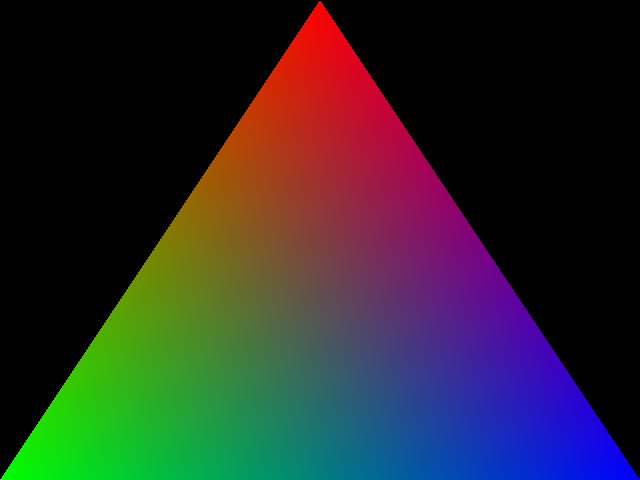

In [0]:
# Let's render something!

vbo = gl.glCreateBuffers()
gl.glBindBuffer(
    gl.GL_ARRAY_BUFFER,
    vbo
)
attribLocation = gl.glGetAttribLocation(main_program, "POSITION")
accessor, buffer = glTF_tools.accessor(0, model, buffers)
mesh = model['meshes'][0]
mesh['']
# Read the result
img_buf = gl.glReadPixelsub(0, 0, WIDTH, HEIGHT, gl.GL_RGB, gl.GL_UNSIGNED_BYTE)
img = np.frombuffer(img_buf, np.uint8).reshape(HEIGHT, WIDTH, 3)[::-1]
show.image(img/255.0)

##  Render ShaderToy videos on GPU

We now have the full power of modern OpenGL in our hands! Let's do something interesting with it!

Fetching the source and rendering the [amaizing shader](https://www.shadertoy.com/view/Xtf3Rn) by Kali from [ShaderToy](https://www.shadertoy.com/view/Xtf3Rn). You can also  substitute a different `shader_id`, but note that only single-pass shaders that don't use textures are supported by the code below.

In [0]:
shader_id = 'Xtf3Rn'  # https://www.shadertoy.com/view/Xtf3Rn

shader_json = !curl -s 'https://www.shadertoy.com/shadertoy' \
  -H 'Referer: https://www.shadertoy.com/view/$shader_id' \
  --data 's=%7B%20%22shaders%22%20%3A%20%5B%22$shader_id%22%5D%20%7D'
shader_data = json.loads(''.join(shader_json))[0]

assert len(shader_data['renderpass']) == 1, "Only single pass shareds are supported"
assert len(shader_data['renderpass'][0]['inputs']) == 0,  "Input channels are not supported"

shader_code = shader_data['renderpass'][0]['code']

In [0]:
import PIL

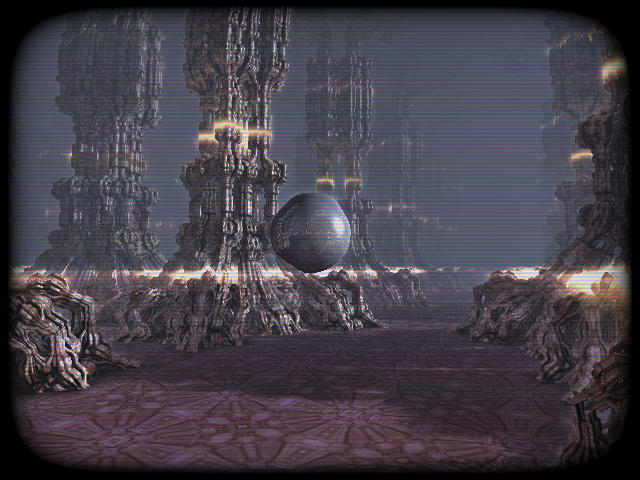

In [14]:
from OpenGL.GL import shaders

vertexPositions = np.float32([[-1, -1], [1, -1], [-1, 1], [1, 1]])
VERTEX_SHADER = shaders.compileShader("""
#version 330
layout(location = 0) in vec4 position;
out vec2 UV;
void main()
{
  UV = position.xy*0.5+0.5;
  gl_Position = position;
}
""", gl.GL_VERTEX_SHADER)

FRAGMENT_SHADER = shaders.compileShader("""
#version 330
out vec4 outputColor;
in vec2 UV;

uniform sampler2D iChannel0;
uniform vec3 iResolution;
vec4 iMouse = vec4(0);
uniform float iTime = 0.0;
""" + shader_code + """
void main()
{
    mainImage(outputColor, UV*iResolution.xy);
}

""", gl.GL_FRAGMENT_SHADER)

shader = shaders.compileProgram(VERTEX_SHADER, FRAGMENT_SHADER)


time_loc = gl.glGetUniformLocation(shader, 'iTime')
res_loc = gl.glGetUniformLocation(shader, 'iResolution')

def render_frame(time):
  gl.glClear(gl.GL_COLOR_BUFFER_BIT)
  with shader:
    gl.glUniform1f(time_loc, time)
    gl.glUniform3f(res_loc, WIDTH, HEIGHT, 1.0)
    
    gl.glEnableVertexAttribArray(0);
    gl.glVertexAttribPointer(0, 2, gl.GL_FLOAT, False, 0, vertexPositions)
    gl.glDrawArrays(gl.GL_TRIANGLE_STRIP, 0, 4)
  img_buf = gl.glReadPixels(0, 0, WIDTH, HEIGHT, gl.GL_RGB, gl.GL_UNSIGNED_BYTE)
  img = np.frombuffer(img_buf, np.uint8).reshape(HEIGHT, WIDTH, 3)[::-1]
  return img
PIL.Image.fromarray(render_frame(10.0))

Use [MoviePy](https://zulko.github.io/moviepy/) to generate a video.

In [0]:
clip = mvp.VideoClip(render_frame, duration=10.0)
clip.write_videofile('out.mp4', fps=60)
files.download('out.mp4')

[MoviePy] >>>> Building video out.mp4
[MoviePy] Writing video out.mp4


100%|█████████▉| 600/601 [00:16<00:00, 35.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out.mp4 

